<div style="background-color: white; color: black; font-family: 'Times New Roman', serif; padding: 50px; max-width: 450px; margin: auto; border: 1px solid #ccc; box-shadow: 0 0 10px rgba(0,0,0,0.1);">
  <div align="center">
    <img src="Imagenes/ugr_escudo_sin.png" alt="Escudo UGR" style="height: 120px;"><br><br>
    <h2 style="margin-bottom: 0;">Universidad de Granada</h2>
    <h3 style="margin-top: 0;">TRABAJO FIN DE GRADO</h3>
    <p style="font-variant: small-caps; font-size: 14px;">
      Doble Grado en Ingeniería Informática y Administración y Dirección de Empresas
    </p>
    <hr style="width: 60%; border: 1px solid black;">
    <h2 style="font-size: 20px;">
      Análisis y Optimización de<br>
      Rutas Aéreas Comerciales<br>
      mediante Ciencia de Datos
    </h2>
    <hr style="width: 60%; border: 1px solid black;">
    <br>
    <p><strong>Autor</strong><br>José Antonio Fernández Aranda</p>
    <p><strong>Director</strong><br>Jorge Casillas Barranquero</p>
    <p><strong><br>Análisis de Vuelos</strong></p>
    <br><br>
    <div style="display: flex; justify-content: center; align-items: center; gap: 80px; flex-wrap: wrap;">
      <img src="https://etsiit.ugr.es/sites/centros/etsiit/public/template-extra/etsiit-logo.png" alt="Logo ETSIIT" style="height: 100px;">
      <img src="Imagenes/logo_decsai.png" alt="Logo DECSAI" style="height: 100px;">
    </div>
    <br>
    <p style="font-size: 14px;">
      Escuela Técnica Superior de Ingenierías Informática y de Telecomunicación<br>
      —<br>
      Granada, a 8 de junio de 2025
    </p>
  </div>
</div>

# Análisis de Vuelos

### Bibliotecas

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, Birch, MeanShift, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Cargar y Unir Data Set

In [12]:
# Cargar y unir datasets de vuelos
ruta1 = "Vuelos_datos/vuelos_con_duracion_CALCULADO.xlsx"
ruta2 = "Vuelos_datos/3_vuelos_con_duracion_CALCULADO.xlsx"

df1 = pd.read_excel(ruta1)
df2 = pd.read_excel(ruta2)

# Unificar y normalizar columnas
df = pd.concat([df1, df2], ignore_index=True)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

## Preprocesamiento

In [13]:
df_clust = df.copy()

# Convertir hora de salida a valor numérico (hora)
df_clust["hora_salida_num"] = pd.to_datetime(df_clust["hora_salida"], errors='coerce').dt.hour

# Duración como numérico
df_clust["duracion_min"] = pd.to_numeric(df_clust["duración_(min)"], errors='coerce')

# Limpiar texto y codificar
df_clust["tipo"] = df_clust["tipo"].astype(str).str.strip().str.upper()
df_clust["aerolínea"] = df_clust["aerolínea"].astype(str).str.strip().str.upper()

# Eliminar filas con datos clave faltantes
df_clust = df_clust.dropna(subset=["hora_salida_num", "duracion_min", "tipo", "aerolínea"])

# Codificación one-hot
df_clust = pd.get_dummies(df_clust, columns=["tipo", "aerolínea"], drop_first=True)

# Selección de variables para clustering
features_clustering = df_clust[["hora_salida_num", "duracion_min"] +
                               [col for col in df_clust.columns if col.startswith("tipo_") or col.startswith("aerolínea_")]].copy()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_clustering)

print(f"Dataset escalado listo para clustering: {X_scaled.shape[0]} registros y {X_scaled.shape[1]} variables")

df_clust.head()


C:\Users\janto\AppData\Local\Temp\ipykernel_7456\1734124930.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clust["hora_salida_num"] = pd.to_datetime(df_clust["hora_salida"], errors='coerce').dt.hour


Dataset escalado listo para clustering: 5822 registros y 500 variables


,ident,origen,destino,salida,llegada_estimada,fecha_salida,hora_salida,zona_horaria_salida,fecha_llegada,hora_llegada,...,aerolínea_WIF,aerolínea_WIS,aerolínea_WJA,aerolínea_WMT,aerolínea_WUK,aerolínea_WUP,aerolínea_WWI,aerolínea_WZZ,aerolínea_XAX,aerolínea_XEN
0,CSN301,Int'l Cantón Baiyun (CAN / ZGGG),Int'l Kingsford Smith (SYD / YSSY),mar 08:35AM CST,mar 07:16PM AEST,mar,08:35AM,CST,mar,07:16PM,...,False,False,False,False,False,False,False,False,False,False
1,CSN303,Int'l Cantón Baiyun (CAN / ZGGG),Londres-Heathrow (LHR / EGLL),mar 02:16PM CST,mar 07:24PM BST,mar,02:16PM,CST,mar,07:24PM,...,False,False,False,False,False,False,False,False,False,False
2,CSN3038,Int'l Soekarno-Hatta (CGK / WIII),Int'l Cantón Baiyun (CAN / ZGGG),mar 01:38PM WIB,mar 07:23PM CST,mar,01:38PM,WIB,mar,07:23PM,...,False,False,False,False,False,False,False,False,False,False
3,CSN3039,Int'l Cantón Baiyun (CAN / ZGGG),Int'l de Singapur (SIN / WSSS),mar 01:14PM CST,mar 04:53PM +08,mar,01:14PM,CST,mar,04:53PM,...,False,False,False,False,False,False,False,False,False,False
4,CSN304,Londres-Heathrow (LHR / EGLL),Int'l Cantón Baiyun (CAN / ZGGG),lun 10:12PM BST,mar 04:12PM CST,lun,10:12PM,BST,mar,04:12PM,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# Asegurar columnas
df_clust["salida_datetime"] = pd.to_datetime(df_clust["salida_datetime"], errors="coerce")
df_clust["zona_horaria_salida"] = df_clust["zona_horaria_salida"].astype(str).str.strip()
df_clust["zona_horaria_llegada"] = df_clust["zona_horaria_llegada"].astype(str).str.strip()

# Mapear zonas horarias a offset UTC aproximado
zona_to_utc = {
    "AST": -4, "EST": -5, "EDT": -4, "CEST": 2, "WEST": 1,
    "AEST": 10, "BST": 1, "+03": 3, "+07": 7, "IST": 5.5,
    "UTC": 0, "GMT": 0, "CET": 1
}
df_clust["utc_offset_salida"] = df_clust["zona_horaria_salida"].map(zona_to_utc)
df_clust["utc_offset_llegada"] = df_clust["zona_horaria_llegada"].map(zona_to_utc)
df_clust["delta_utc"] = df_clust["utc_offset_llegada"] - df_clust["utc_offset_salida"]

# Día de la semana y mes
df_clust["dia_semana"] = df_clust["salida_datetime"].dt.dayofweek
df_clust["mes_salida"] = df_clust["salida_datetime"].dt.month
df_clust["es_finde"] = df_clust["dia_semana"].isin([5, 6]).astype(int)

# Variable vuelo internacional aproximada
df_clust["origen_simple"] = df_clust["origen"].astype(str).str.split("(").str[0].str.strip()
df_clust["destino_simple"] = df_clust["destino"].astype(str).str.split("(").str[0].str.strip()
df_clust["vuelo_internacional"] = (df_clust["origen_simple"] != df_clust["destino_simple"]).astype(int)

# Verificamos
df_clust[["hora_salida_num", "duracion_min", "dia_semana", "mes_salida", 
          "es_finde", "delta_utc", "vuelo_internacional"]].describe()


,hora_salida_num,duracion_min,dia_semana,mes_salida,es_finde,delta_utc,vuelo_internacional
count,5822.000000,5822.000000,5822.000000,5822.0,5822.0,2012.000000,5822.000000
mean,12.850052,149.633803,2.987633,3.0,0.0,-0.275348,0.998798
std,6.025715,372.193112,0.301491,0.0,0.0,2.023231,0.034657
min,0.000000,-2131.000000,2.000000,3.0,0.0,-9.500000,0.000000
25%,9.000000,68.000000,3.000000,3.0,0.0,0.000000,1.000000
50%,14.000000,127.500000,3.000000,3.0,0.0,0.000000,1.000000
75%,17.000000,253.000000,3.000000,3.0,0.0,0.000000,1.000000
max,23.000000,2176.000000,4.000000,3.0,0.0,9.500000,1.000000


## Algoritmos de Clustering

### KMeans

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Buscar el mejor número de clusters entre 2 y 10
mejor_k = 0
mejor_score = -1
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > mejor_score:
        mejor_score = score
        mejor_k = k

# Entrenar con mejor k
modelo_kmeans = KMeans(n_clusters=mejor_k, random_state=42)
labels_kmeans = modelo_kmeans.fit_predict(X_scaled)

# Guardar para visualización futura si quieres
df_clust["cluster_kmeans"] = labels_kmeans

# Métricas
s_k = silhouette_score(X_scaled, labels_kmeans)
c_k = calinski_harabasz_score(X_scaled, labels_kmeans)
d_k = davies_bouldin_score(X_scaled, labels_kmeans)

print(f" KMeans con k = {mejor_k}")
print(f" Coeficiente de Silueta     : {s_k:.3f}")
print(f" Calinski-Harabasz          : {c_k:.2f}")
print(f" Davies-Bouldin             : {d_k:.3f}")


 KMeans con k = 2
 Coeficiente de Silueta     : 0.568
 Calinski-Harabasz          : 12.71
 Davies-Bouldin             : 0.613


### DBSCAN

In [16]:
from sklearn.cluster import DBSCAN

mejor_eps = None
mejor_silhouette = -1
mejor_labels = None

for eps in np.arange(0.8, 1.8, 0.1):
    try:
        dbscan = DBSCAN(eps=eps, min_samples=50)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue
        score = silhouette_score(X_scaled, labels)
        if score > mejor_silhouette:
            mejor_silhouette = score
            mejor_eps = eps
            mejor_labels = labels
    except:
        continue

# Entrenar DBSCAN final
modelo_dbscan = DBSCAN(eps=mejor_eps, min_samples=8)
labels_dbscan = modelo_dbscan.fit_predict(X_scaled)
df_clust["cluster_dbscan"] = labels_dbscan

# Métricas
s_d = silhouette_score(X_scaled, labels_dbscan)
c_d = calinski_harabasz_score(X_scaled, labels_dbscan)
d_d = davies_bouldin_score(X_scaled, labels_dbscan)
n_clusters_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

print(f" DBSCAN con eps = {mejor_eps:.2f}, min_samples = 50")
print(f" Clusters encontrados     : {n_clusters_db}")
print(f" Coeficiente Silueta      : {s_d:.3f}")
print(f" Calinski-Harabasz        : {c_d:.2f}")
print(f" Davies-Bouldin           : {d_d:.3f}")


 DBSCAN con eps = 1.60, min_samples = 50
 Clusters encontrados     : 182
 Coeficiente Silueta      : 0.167
 Calinski-Harabasz        : 7.97
 Davies-Bouldin           : 1.663


### Birch

In [17]:
from sklearn.cluster import Birch

mejor_k_birch = 0
mejor_score_birch = -1

for k in range(2, 11):
    modelo = Birch(n_clusters=k)
    labels = modelo.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > mejor_score_birch:
        mejor_score_birch = score
        mejor_k_birch = k
        mejor_labels_birch = labels

modelo_birch = Birch(n_clusters=mejor_k_birch)
labels_birch = modelo_birch.fit_predict(X_scaled)
df_clust["cluster_birch"] = labels_birch

# Métricas
s_b = silhouette_score(X_scaled, labels_birch)
c_b = calinski_harabasz_score(X_scaled, labels_birch)
d_b = davies_bouldin_score(X_scaled, labels_birch)

print(f" Birch con k =              {mejor_k_birch}")
print(f" Coeficiente Silueta        : {s_b:.3f}")
print(f" Calinski-Harabasz          : {c_b:.2f}")
print(f" Davies-Bouldin             : {d_b:.3f}")


 Birch con k =              9
 Coeficiente Silueta        : 0.754
 Calinski-Harabasz          : 24.03
 Davies-Bouldin             : 0.169


### MeanShift

In [18]:
from sklearn.cluster import MeanShift

modelo_meanshift = MeanShift()
labels_meanshift = modelo_meanshift.fit_predict(X_scaled)
df_clust["cluster_meanshift"] = labels_meanshift

# Métricas
s_m = silhouette_score(X_scaled, labels_meanshift)
c_m = calinski_harabasz_score(X_scaled, labels_meanshift)
d_m = davies_bouldin_score(X_scaled, labels_meanshift)
n_m = len(set(labels_meanshift))

print(f" MeanShift")
print(f" Clusters encontrados     : {n_m}")
print(f" Coeficiente Silueta      : {s_m:.3f}")
print(f" Calinski-Harabasz        : {c_m:.2f}")
print(f" Davies-Bouldin           : {d_m:.3f}")


 MeanShift
 Clusters encontrados     : 317
 Coeficiente Silueta      : 0.341
 Calinski-Harabasz        : 30.15
 Davies-Bouldin           : 0.330


### Agglomerative Clustering – jerárquico

In [24]:
from sklearn.cluster import AgglomerativeClustering

modelo_aggl = AgglomerativeClustering(n_clusters=6)
labels_aggl = modelo_aggl.fit_predict(X_scaled)
df_clust["cluster_agglomerative"] = labels_aggl

# Métricas
s_a = silhouette_score(X_scaled, labels_aggl)
c_a = calinski_harabasz_score(X_scaled, labels_aggl)
d_a = davies_bouldin_score(X_scaled, labels_aggl)

print(f" Clustering Aglomerativo (k = 6)")
print(f" Coeficiente Silueta        : {s_a:.3f}")
print(f" Calinski-Harabasz          : {c_a:.2f}")
print(f" Davies-Bouldin             : {d_a:.3f}")


 Clustering Aglomerativo (k = 6)
 Coeficiente Silueta        : 0.356
 Calinski-Harabasz          : 23.78
 Davies-Bouldin             : 4.901


### Visualización 

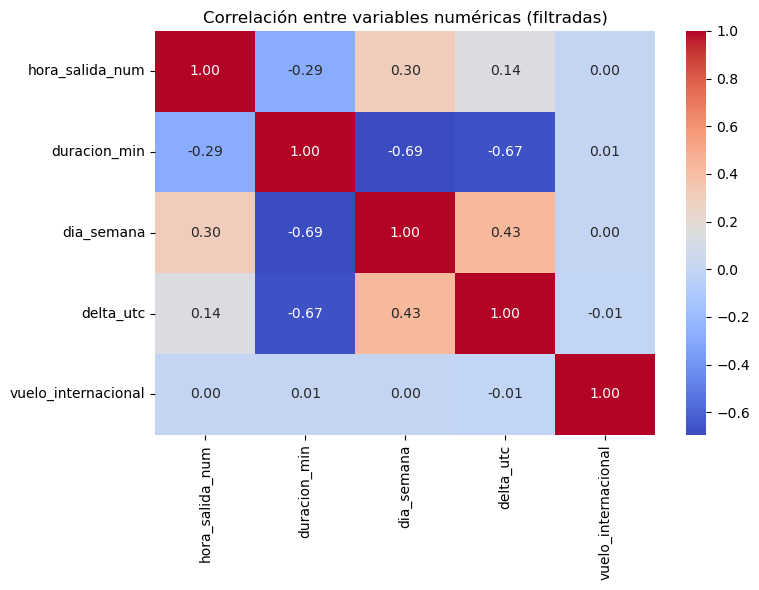

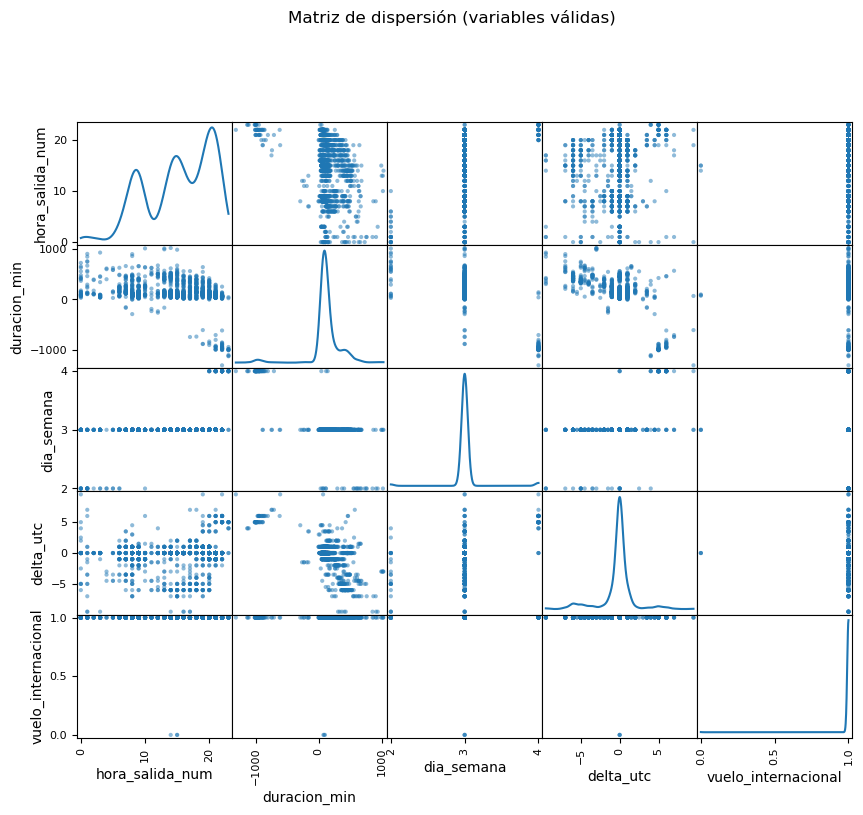

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Variables candidatas
vars_numericas = [
    "hora_salida_num",
    "duracion_min",
    "dia_semana",
    "mes_salida",
    "es_finde",
    "delta_utc",
    "vuelo_internacional"
]

# Selección con varianza distinta de cero
df_numericas = df_clust[vars_numericas].dropna()
vars_validas = [col for col in df_numericas.columns if df_numericas[col].nunique() > 1]

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_numericas[vars_validas].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables numéricas (filtradas)")
plt.tight_layout()
plt.show()

# Scatter matrix
scatter_matrix(df_numericas[vars_validas], figsize=(10, 8), diagonal='kde')
plt.suptitle("Matriz de dispersión (variables válidas)", y=1.02)
plt.show()



### Heatmap

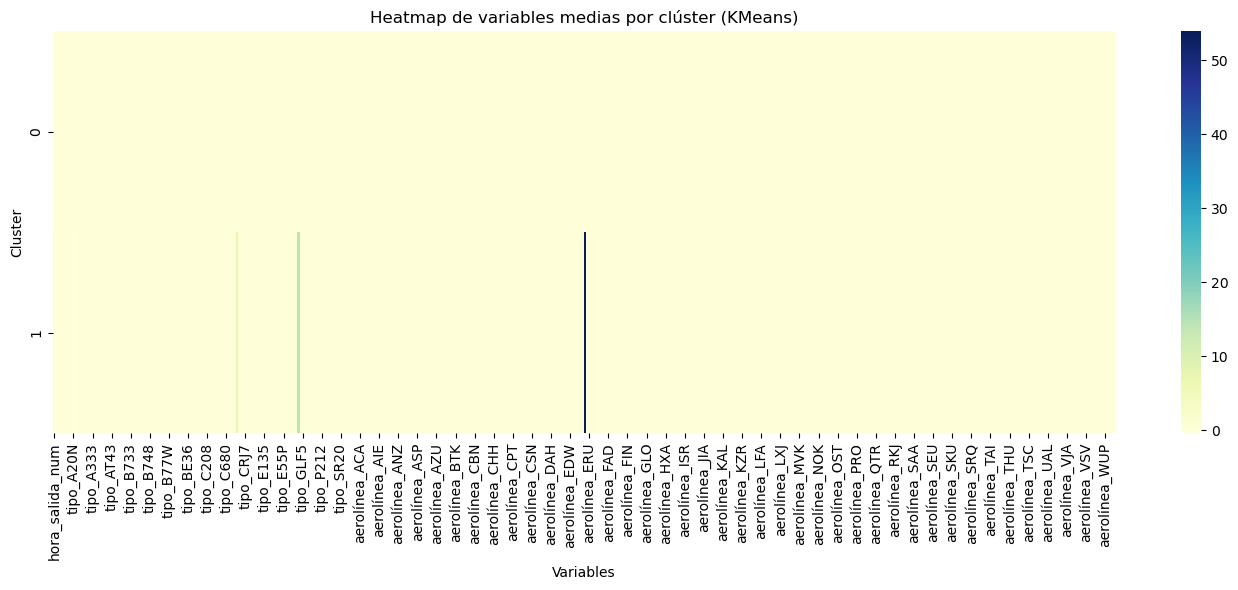

In [26]:
X_kmeans = pd.DataFrame(X_scaled, columns=features_clustering.columns)
X_kmeans["cluster"] = labels_kmeans

# Agrupar por clúster y promediar
cluster_means = X_kmeans.groupby("cluster").mean()

# Visualizar como heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_means, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Heatmap de variables medias por clúster (KMeans)")
plt.xlabel("Variables")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


### Scatter Matrix

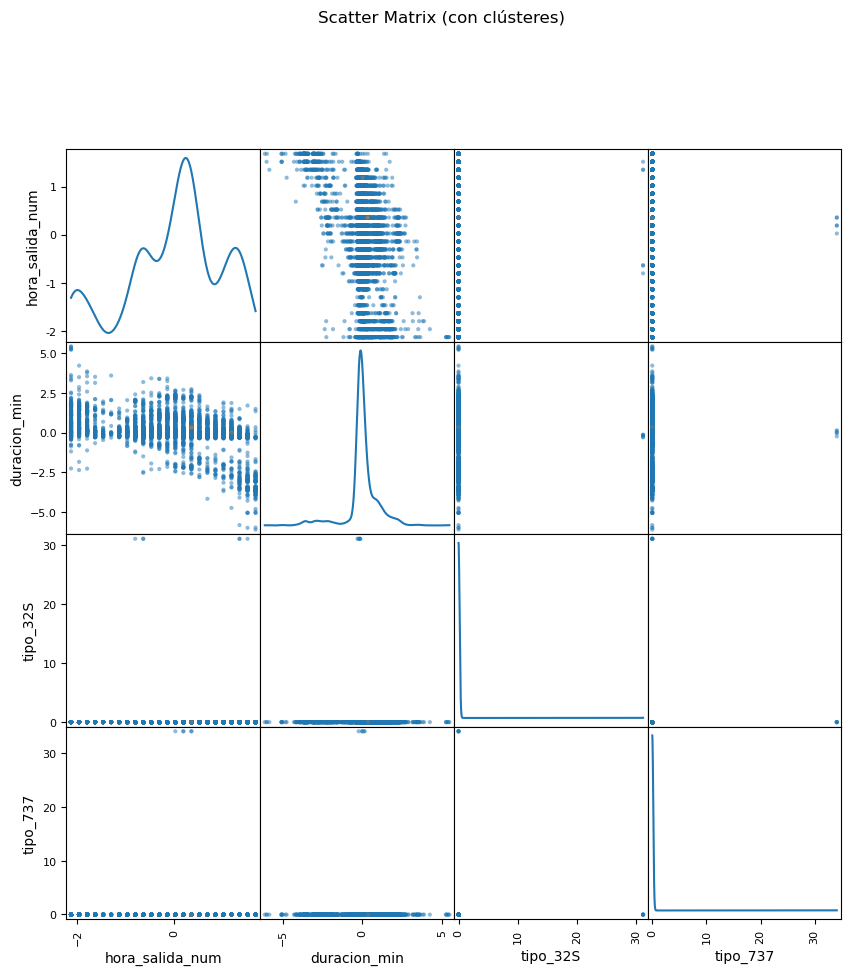

In [27]:
from pandas.plotting import scatter_matrix

# Seleccionamos 4-5 variables numéricas originales para no saturar
vars_plot = ["hora_salida_num", "duracion_min"] + [c for c in X_kmeans.columns if "tipo_" in c][:2]

# Añadir el clúster como color
df_vis = X_kmeans[vars_plot + ["cluster"]].copy()
df_vis["cluster"] = df_vis["cluster"].astype(str)

# Mostrar matriz de dispersión
scatter_matrix(df_vis[vars_plot], figsize=(10, 10), diagonal='kde', color=df_vis["cluster"].map({
    str(i): plt.cm.tab10(i) for i in range(df_vis["cluster"].nunique())
}))
plt.suptitle("Scatter Matrix (con clústeres)", y=1.02)
plt.show()


### Dendograma

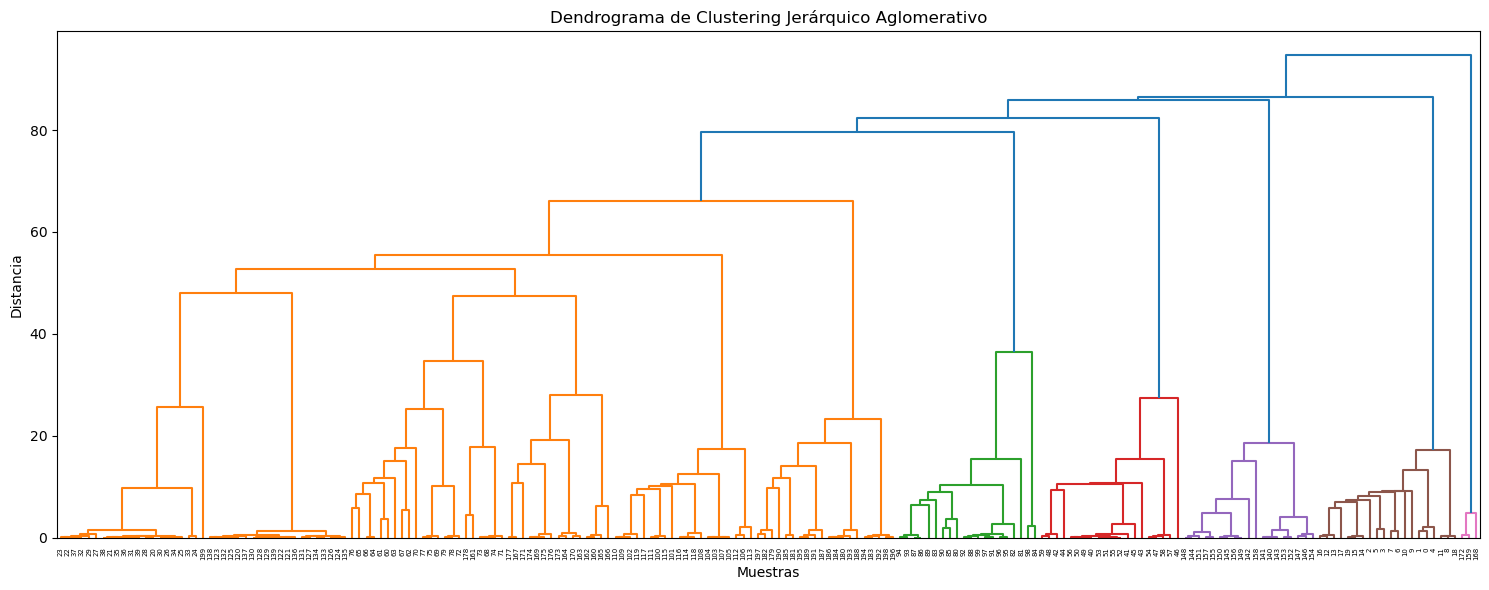

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Seleccionamos una muestra aleatoria si hay muchos datos
X_subsample = X_scaled[:200]  

# Cálculo de linkage
linked = linkage(X_subsample, method='ward')

plt.figure(figsize=(15, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title("Dendrograma de Clustering Jerárquico Aglomerativo")
plt.xlabel("Muestras")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()


## Visualización

C:\Users\janto\AppData\Local\Temp\ipykernel_7456\4015936298.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_base["hora_salida_num"] = pd.to_datetime(df_base["hora_salida"], errors='coerce').dt.hour
c:\Users\janto\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


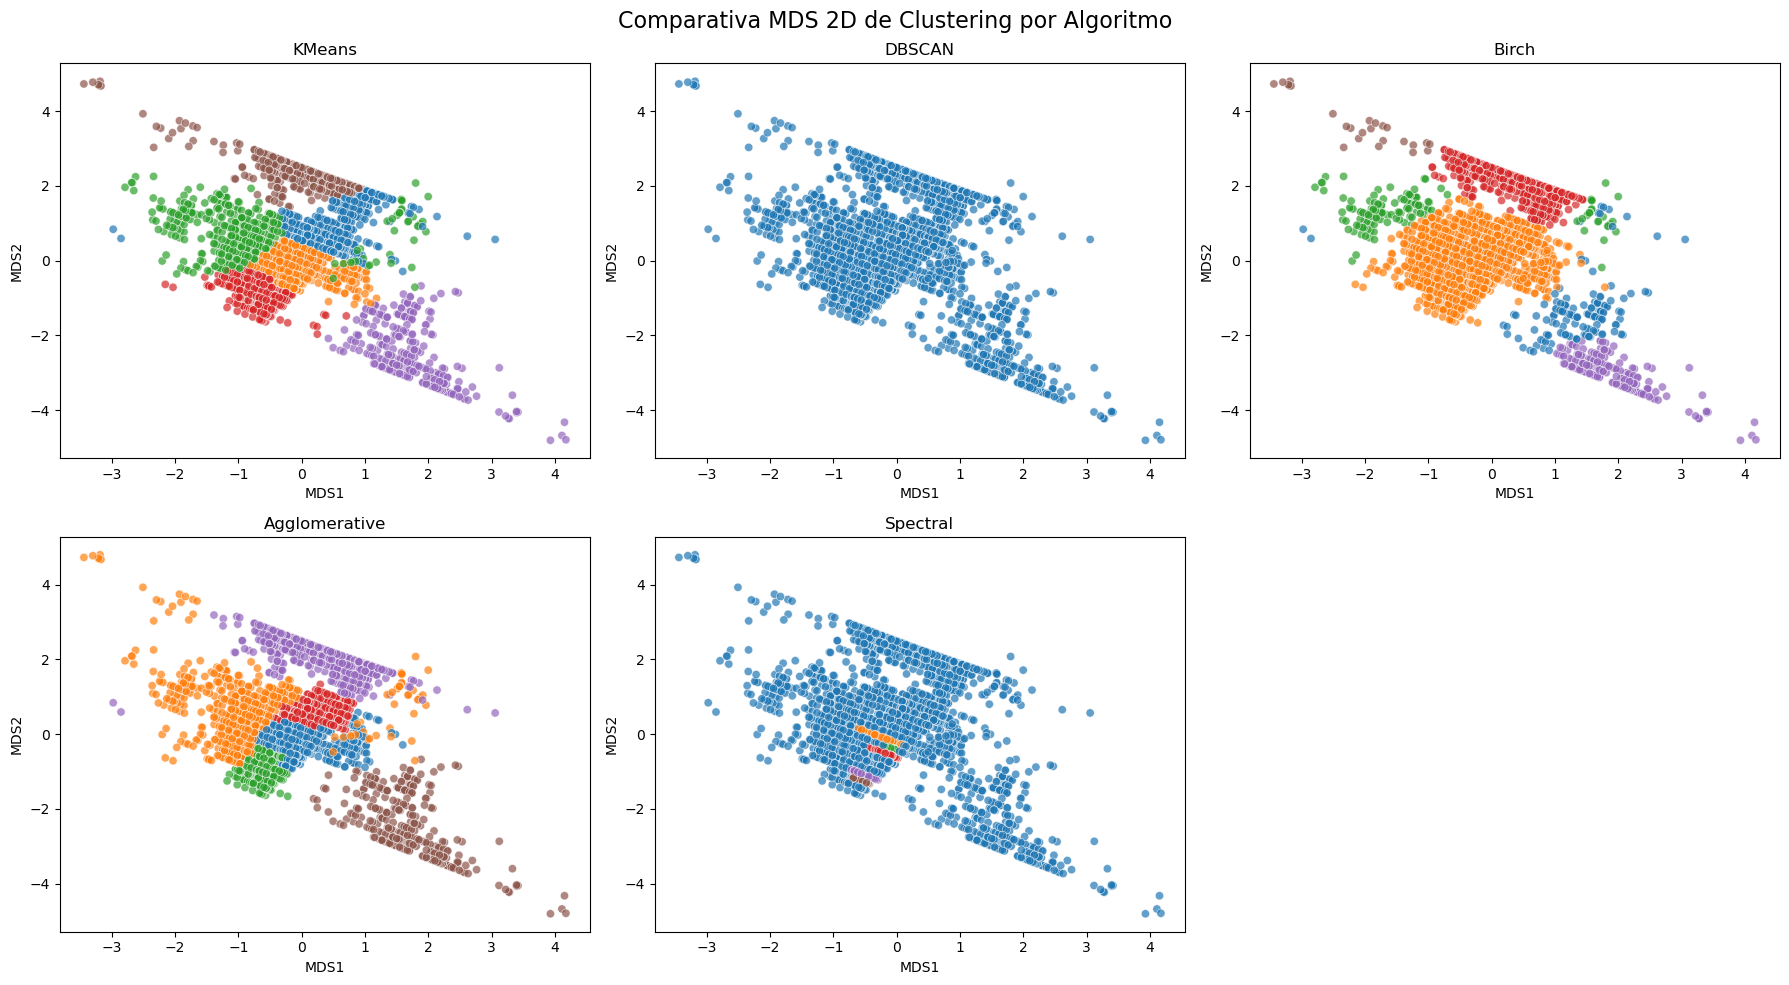

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, DBSCAN, Birch, AgglomerativeClustering, SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Variables base
df_base = df.copy()
df_base["hora_salida_num"] = pd.to_datetime(df_base["hora_salida"], errors='coerce').dt.hour
df_base["duracion_min"] = pd.to_numeric(df_base["duración_(min)"], errors='coerce')
df_base = df_base.dropna(subset=["hora_salida_num", "duracion_min"])

X_base = df_base[["hora_salida_num", "duracion_min"]].copy()
X_base = StandardScaler().fit_transform(X_base)

# MDS en lugar de PCA
mds = MDS(n_components=2, dissimilarity="euclidean", random_state=42)
X_mds = mds.fit_transform(X_base)

# Clustering con varios algoritmos
labels_dict = {
    "KMeans": KMeans(n_clusters=6, random_state=42).fit_predict(X_base),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=8).fit_predict(X_base),
    "Birch": Birch(n_clusters=6).fit_predict(X_base),
    "Agglomerative": AgglomerativeClustering(n_clusters=6).fit_predict(X_base),
    "Spectral": SpectralClustering(n_clusters=6, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42).fit_predict(X_base)
}

# Visualización MDS 2D para cada algoritmo
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for ax, (name, labels) in zip(axs.flat, labels_dict.items()):
    df_temp = pd.DataFrame(X_mds, columns=["MDS1", "MDS2"])
    df_temp["cluster"] = labels.astype(str)
    sns.scatterplot(data=df_temp, x="MDS1", y="MDS2", hue="cluster", palette="tab10", alpha=0.7, ax=ax, legend=False)
    ax.set_title(f"{name}")
    ax.set_xlabel("MDS1")
    ax.set_ylabel("MDS2")

axs[1, 2].axis("off")  # Eliminar la última celda vacía

plt.suptitle("Comparativa MDS 2D de Clustering por Algoritmo", fontsize=16)
plt.tight_layout()
plt.show()




### Perfil del cluster

In [30]:
# Crear columnas necesarias para el perfil extendido
df_base["salida_datetime"] = pd.to_datetime(df_base["salida_datetime"], errors="coerce")
df_base["dia_semana"] = df_base["salida_datetime"].dt.dayofweek
df_base["es_finde"] = df_base["dia_semana"].isin([5, 6]).astype(int)

# Mapear zonas horarias a UTC
zona_to_utc = {
    "AST": -4, "EST": -5, "EDT": -4, "CEST": 2, "WEST": 1,
    "AEST": 10, "BST": 1, "+03": 3, "+07": 7, "IST": 5.5,
    "UTC": 0, "GMT": 0, "CET": 1
}
df_base["zona_horaria_salida"] = df_base["zona_horaria_salida"].astype(str).str.strip()
df_base["zona_horaria_llegada"] = df_base["zona_horaria_llegada"].astype(str).str.strip()
df_base["utc_offset_salida"] = df_base["zona_horaria_salida"].map(zona_to_utc)
df_base["utc_offset_llegada"] = df_base["zona_horaria_llegada"].map(zona_to_utc)
df_base["delta_utc"] = df_base["utc_offset_llegada"] - df_base["utc_offset_salida"]

# Determinar si es vuelo internacional
df_base["origen_simple"] = df_base["origen"].astype(str).str.split("(").str[0].str.strip()
df_base["destino_simple"] = df_base["destino"].astype(str).str.split("(").str[0].str.strip()
df_base["vuelo_internacional"] = (df_base["origen_simple"] != df_base["destino_simple"]).astype(int)


In [31]:
print(df_base.columns)


Index(['ident', 'tipo', 'origen', 'destino', 'salida', 'llegada_estimada',
       'aerolínea', 'fecha_salida', 'hora_salida', 'zona_horaria_salida',
       'fecha_llegada', 'hora_llegada', 'zona_horaria_llegada',
       'salida_datetime', 'llegada_datetime', 'duración_(min)',
       'duración_(hh:mm)', 'hora_salida_num', 'duracion_min', 'dia_semana',
       'es_finde', 'utc_offset_salida', 'utc_offset_llegada', 'delta_utc',
       'origen_simple', 'destino_simple', 'vuelo_internacional'],
      dtype='object')


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X_base = df_base[["hora_salida_num", "duracion_min"]].dropna()
X_scaled = StandardScaler().fit_transform(X_base)

df_base = df_base.loc[X_base.index]  
df_base["cluster_kmeans"] = KMeans(n_clusters=6, random_state=42).fit_predict(X_scaled)


In [33]:
vars_numericas = [
    "hora_salida_num", "duracion_min",
    "dia_semana", "es_finde", "delta_utc", "vuelo_internacional"
]

perfil_kmeans = df_base.groupby("cluster_kmeans")[vars_numericas].agg(['mean', 'std', 'min', 'max']).round(2)
perfil_kmeans


hora_salida_num               duracion_min                  \
                          mean   std min max         mean     std     min   
cluster_kmeans                                                              
0                        14.08  1.50  11  17       112.12   94.31  -426.0   
1                         1.04  1.30   0   6       598.42  321.80   179.0   
2                         6.86  3.05   0  10       135.64  112.97  -732.0   
3                        20.03  1.32  17  23       136.28  104.70  -370.0   
4                        20.00  3.32   9  23      -924.07  302.12 -2131.0   
5                        12.87  2.55   7  22       635.42  214.37   365.0   

                       dia_semana        ... es_finde     delta_utc        \
                   max       mean   std  ...      min max      mean   std   
cluster_kmeans                           ...                                
0                383.0       3.00  0.02  ...        0   0     -0.25  1.30   
1               2176.0       2.50  0.50  ...        0   0     -2.31  4.04   
2                503.0       2.94  0.24  ...        0   0     -0.20  1.21   
3                705.0       3.01  0.09  ...        0   0     -0.27  1.61   
4               -402.0       3.61  0.49  ...        0   0      5.57  1.04   
5               1424.0       2.99  0.08  ...        0   0     -2.53  3.27   

                         vuelo_internacional                
                min  max                mean   std min max  
cluster_kmeans                                              
0              -9.5  4.0                 1.0  0.05   0   1  
1              -9.5  7.0                 1.0  0.00   1   1  
2              -6.0  9.5                 1.0  0.00   1   1  
3              -9.5  4.5                 1.0  0.03   0   1  
4               4.0  9.5                 1.0  0.00   1   1  
5              -9.5  6.0                 1.0  0.00   1   1  

[6 rows x 24 columns]

In [34]:
# Variables numéricas relevantes
vars_numericas = [
    "hora_salida_num", "duracion_min",
    "dia_semana", "es_finde", "delta_utc", "vuelo_internacional"
]

# Agrupar por clúster
perfil_kmeans = df_base.groupby("cluster_kmeans")[vars_numericas].agg(['mean', 'std', 'min', 'max']).round(2)
perfil_kmeans


hora_salida_num               duracion_min                  \
                          mean   std min max         mean     std     min   
cluster_kmeans                                                              
0                        14.08  1.50  11  17       112.12   94.31  -426.0   
1                         1.04  1.30   0   6       598.42  321.80   179.0   
2                         6.86  3.05   0  10       135.64  112.97  -732.0   
3                        20.03  1.32  17  23       136.28  104.70  -370.0   
4                        20.00  3.32   9  23      -924.07  302.12 -2131.0   
5                        12.87  2.55   7  22       635.42  214.37   365.0   

                       dia_semana        ... es_finde     delta_utc        \
                   max       mean   std  ...      min max      mean   std   
cluster_kmeans                           ...                                
0                383.0       3.00  0.02  ...        0   0     -0.25  1.30   
1               2176.0       2.50  0.50  ...        0   0     -2.31  4.04   
2                503.0       2.94  0.24  ...        0   0     -0.20  1.21   
3                705.0       3.01  0.09  ...        0   0     -0.27  1.61   
4               -402.0       3.61  0.49  ...        0   0      5.57  1.04   
5               1424.0       2.99  0.08  ...        0   0     -2.53  3.27   

                         vuelo_internacional                
                min  max                mean   std min max  
cluster_kmeans                                              
0              -9.5  4.0                 1.0  0.05   0   1  
1              -9.5  7.0                 1.0  0.00   1   1  
2              -6.0  9.5                 1.0  0.00   1   1  
3              -9.5  4.5                 1.0  0.03   0   1  
4               4.0  9.5                 1.0  0.00   1   1  
5              -9.5  6.0                 1.0  0.00   1   1  

[6 rows x 24 columns]

C:\Users\janto\AppData\Local\Temp\ipykernel_7456\1134573565.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_clean[df_clean["tipo"].isin(top_tipos)], x="tipo", y="duracion_min", estimator=np.mean, ci=None)


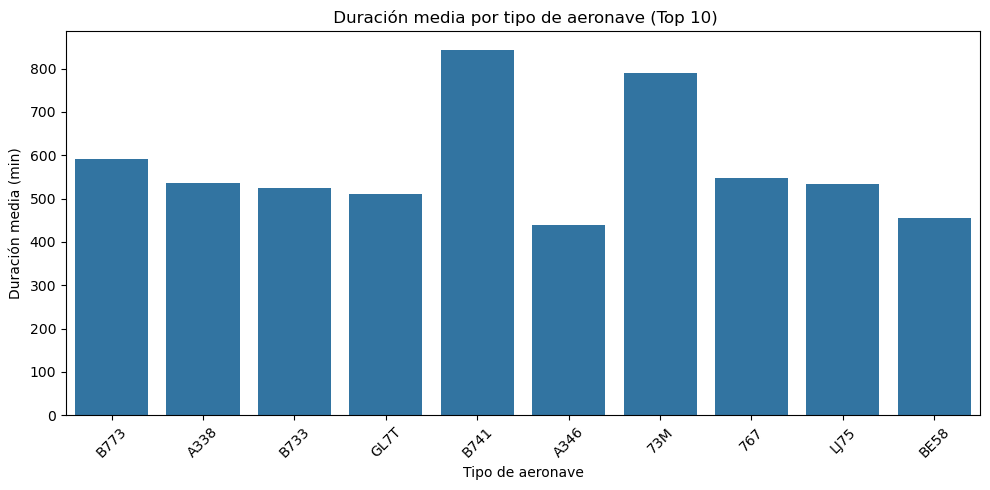

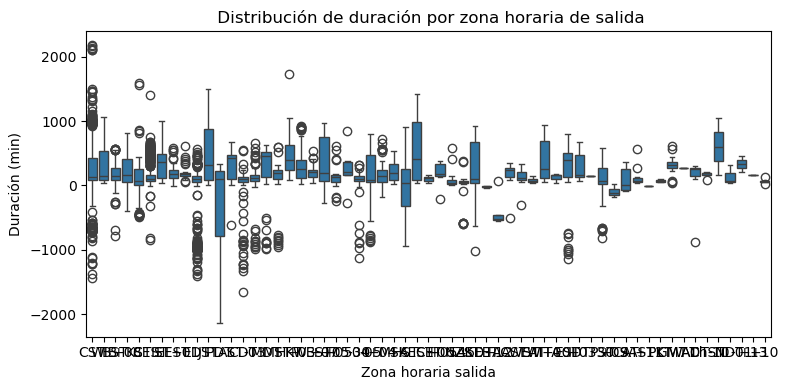

 Duración media por tipo de aeronave:


,count,mean,std
tipo,,,
B741,1,844.000000,NaN
73M,1,789.000000,NaN
B773,15,591.733333,213.013570
767,1,548.000000,NaN
A338,3,536.000000,284.100334
LJ75,2,534.000000,670.337229
B733,2,525.500000,584.777308
GL7T,5,510.000000,228.057010
BE58,1,456.000000,NaN



 Duración media por operador (ident):


,count,mean,std
ident,,,
EVA16,1,2176.0,NaN
SJX2,1,2158.0,NaN
EVA28,1,2140.0,NaN
SJX12,1,2115.0,NaN
EVA26,1,2104.0,NaN
CAL32,1,2096.0,NaN
CPA872,1,1722.0,NaN
KAL213,1,1556.0,NaN
ANA106,1,1501.0,NaN



 Duración media por zona horaria de salida:


,count,mean,std
zona_horaria_salida,,,
-10,2,602.000000,626.496608
AEST,65,528.123077,465.087710
JST,114,484.385965,406.157246
HKT,55,465.981818,311.659269
WITA,27,409.666667,321.377205
+07,192,350.739583,344.150026
IST,141,347.127660,243.334833
-01,2,334.000000,169.705627
AST,82,332.829268,215.213635


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preparación del DataFrame base
df = df_base.copy() 
df["tipo"] = df["tipo"].astype(str).str.strip().str.upper()
df["duracion_min"] = pd.to_numeric(df["duración_(min)"], errors='coerce')

df["zona_horaria_salida"] = df["zona_horaria_salida"].astype(str).str.strip()
df["zona_horaria_llegada"] = df["zona_horaria_llegada"].astype(str).str.strip()

# Filtrar datos válidos
df_clean = df.dropna(subset=["tipo", "duracion_min", "zona_horaria_salida", "zona_horaria_llegada"]).copy()

# Estadísticas por tipo de aeronave
duracion_por_tipo = df_clean.groupby("tipo")["duracion_min"].agg(["count", "mean", "std"]).sort_values(by="mean", ascending=False)

# Estadísticas por operador (ident)
duracion_por_operador = df_clean.groupby("ident")["duracion_min"].agg(["count", "mean", "std"]).sort_values(by="mean", ascending=False)

# Estadísticas por zona horaria de salida
duracion_por_zona = df_clean.groupby("zona_horaria_salida")["duracion_min"].agg(["count", "mean", "std"]).sort_values(by="mean", ascending=False)

# Gráfico: duración media por tipo de aeronave (Top 10)
top_tipos = duracion_por_tipo.head(10).index

plt.figure(figsize=(10, 5))
sns.barplot(data=df_clean[df_clean["tipo"].isin(top_tipos)], x="tipo", y="duracion_min", estimator=np.mean, ci=None)
plt.title(" Duración media por tipo de aeronave (Top 10)")
plt.ylabel("Duración media (min)")
plt.xlabel("Tipo de aeronave")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot: duración por zona horaria de salida
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_clean, x="zona_horaria_salida", y="duracion_min")
plt.title(" Distribución de duración por zona horaria de salida")
plt.xlabel("Zona horaria salida")
plt.ylabel("Duración (min)")
plt.tight_layout()
plt.show()

# Mostrar primeras filas de cada resumen
print(" Duración media por tipo de aeronave:")
display(duracion_por_tipo.head(10))

print("\n Duración media por operador (ident):")
display(duracion_por_operador.head(10))

print("\n Duración media por zona horaria de salida:")
display(duracion_por_zona)
